In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn import preprocessing
import pickle as pkl
from pathlib import Path

#import seaborn as sns

c:\users\sa_li\anaconda3\envs\rnn-tf-ker\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#import data as array
# 8 hits with x,y,z

testset = pd.read_pickle('matched_8hittracks.pkl')
#print(testset)

In [3]:
#Check testset with arbitrary particle

tset = np.array(testset)
tset = tset.astype('float32')
#print(tset.shape)
#for i in range(8):
    #print(tset[1,3*i:(3*i+3)])
#print(tset[0,:])

In [4]:
### Reshape original array into the shape (particlenumber, timesteps, input = coordinates)###

def reshapor(arr_orig, num_inputs=3):
    timesteps = int(arr_orig.shape[1]/num_inputs)
    number_examples = int(arr_orig.shape[0])
    arr = np.zeros((number_examples, timesteps, num_inputs))
    
    for i in range(number_examples):
        for t in range(timesteps):
            arr[i,t,:] = arr_orig[i,num_inputs*t:num_inputs*t+num_inputs]
        
    return arr

def reshapor_inv(array_shaped, num_inputs=3):
    timesteps = int(array_shaped.shape[1])
    num_examples = int(array_shaped.shape[0])
    arr = np.zeros((num_examples, timesteps*num_inputs))
    
    for i in range(num_examples):
        for t in range(timesteps):
            arr[i,num_inputs*t:num_inputs*t+num_inputs] = array_shaped[i,t,:]
        
    return arr

In [5]:
### create the training set and the test set###

def create_random_sets(dataset, train_to_total_ratio):
    #shuffle the dataset
    num_examples = dataset.shape[0]
    p = np.random.permutation(num_examples)
    dataset = dataset[p,:]
    
    #evaluate siye of training and test set and initialize them
    train_set_size = np.int(num_examples*train_to_total_ratio)
    test_set_size = num_examples - train_set_size
    
    train_set = np.zeros((train_set_size, dataset.shape[1]))
    test_set = np.zeros((test_set_size, dataset.shape[1]))
   

    #fill train and test sets
    for i in range(num_examples):
        if train_set_size > i:
            train_set[i,:] += dataset[i,:]
        else:
            test_set[i - train_set_size,:]  += dataset[i,:]
                
    return train_set, test_set
        

In [6]:
train_set, test_set = create_random_sets(tset, 0.9)

#print(test_set.shape, train_set.shape, reshapor(tset).shape)
#print(test_set[0,:,:])

In [7]:
#Normalize the data advanced version with scikit learn
def correct_array_steps(arr, steps= 8, num_inputs= 3): #steps > array_steps
        if arr.shape[1] != steps:
            _ = np.zeros((arr.shape[0], steps, num_inputs))
            _[:,:arr.shape[1],:] += arr
            arr = _
        return arr


#set the transormation based on training set
def set_min_max_scaler(arr, feature_range= (-1,1)):
    min_max_scalor = preprocessing.MinMaxScaler(feature_range=feature_range)
    if len(arr.shape) == 3:
        arr = reshapor(min_max_scalor.fit_transform(reshapor_inv(arr)))        
    else:
        arr = min_max_scalor.fit_transform(arr)
    return min_max_scalor

min_max_scalor = set_min_max_scaler(train_set)


#transform data
def min_max_scaler(arr, min_max_scalor= min_max_scalor, num_inputs= 3):
    arr = correct_array_steps(arr)
    arr = reshapor(min_max_scalor.transform(reshapor_inv(arr)))
    return arr
        
#inverse transformation
def min_max_scaler_inv(arr, min_max_scalor= min_max_scalor, num_inputs= 3):
    arr = correct_array_steps(arr)
    arr = reshapor(min_max_scalor.inverse_transform(reshapor_inv(arr)))
    return arr

In [8]:
#Normalize the data advanced version with scikit learn - Standard scaler

#set the transormation based on training set
def set_std_scaler(arr):
    std_scalor = preprocessing.StandardScaler()
    if len(arr.shape) == 3:
        arr = reshapor(std_scalor.fit_transform(reshapor_inv(arr)))        
    else:
        arr = std_scalor.fit_transform(arr)
    return std_scalor

std_scalor = set_std_scaler(train_set)

#transform data
def std_scaler(arr, std_scalor= std_scalor, num_inputs=3):
    arr = correct_array_steps(arr)
    arr = reshapor(std_scalor.transform(reshapor_inv(arr)))
    return arr
        
#inverse transformation
def std_scaler_inv(arr, std_scalor= std_scalor, num_inputs=3):
    arr = correct_array_steps(arr)
    arr = reshapor(std_scalor.inverse_transform(reshapor_inv(arr)))
    return arr



In [9]:
#reshape the data

train_set = reshapor(train_set)
test_set = reshapor(test_set)

#print(train_set[0,:,:])

In [10]:
#Scale data either with MinMax scaler or with Standard scaler
#Return scalor if fit = True and and scaled array otherwise

def scaler(arr, std_scalor= std_scalor, min_max_scalor= min_max_scalor, scalerfunc= "minmax", scalor = False):
    
    if scalor != False:
        arr = correct_array_steps(arr)
        arr = reshapor(scalor.transform(reshapor_inv(arr)))
        return arr
    
    elif scalerfunc == "std":
        arr = std_scaler(arr, std_scalor= std_scalor)
        return arr
    
    elif scalerfunc == "minmax":
        arr = min_max_scaler(arr, min_max_scalor= min_max_scalor)
        return arr
    
    else:
        raise ValueError("Uknown scaler chosen: {}".format(scalerfunc))

def scaler_inv(arr, std_scalor= std_scalor, min_max_scalor= min_max_scalor, scalerfunc= "std", scalor = False, num_inputs= 3):

    if scalor != False:
        arr = correct_array_steps(arr)
        arr = reshapor(scalor.inverse_transform(reshapor_inv(arr)))
        return arr
    
    elif scalerfunc == "std":
        arr = std_scaler_inv(arr, std_scalor= std_scalor)
        return arr
    
    elif scalerfunc == "minmax":
        arr = min_max_scaler_inv(arr, min_max_scalor= min_max_scalor)
        return arr
    
    else:
        raise ValueError("Uknown scaler chosen: {}".format(scalerfunc))


In [11]:
#scale the data

func = "minmax"

train_set = scaler(train_set, scalerfunc = func)
test_set = scaler(test_set, scalerfunc = func)

if func == "minmax":
    scalor = min_max_scalor
elif func == "std":
    scalor = std_scalor

#print(train_set[0,:,:])

In [12]:
###create random mini_batches###


def unison_shuffled_copies(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p,:,:], b[p,:,:]

def random_mini_batches(inputt, target, minibatch_size = 100):
    
    num_examples = inputt.shape[0]
    
    
    #Number of complete batches
    
    number_of_batches = int(num_examples/minibatch_size)
    minibatches = []
   
    #shuffle particles
    _i, _t = unison_shuffled_copies(inputt, target)
    #print(_t.shape)
        
    
    for i in range(number_of_batches):
        
        minibatch_train = _i[minibatch_size*i:minibatch_size*(i+1), :, :]
        
        minibatch_true = _t[minibatch_size*i:minibatch_size*(i+1), :, :]
        
        minibatches.append((minibatch_train, minibatch_true))
        
        
    minibatches.append((_i[number_of_batches*minibatch_size:, :, :], _t[number_of_batches*minibatch_size:, :, :]))
    
    
    return minibatches
        

In [13]:
#Create random minibatches of train and test set with input and target array


minibatches = random_mini_batches(train_set[:,:-1,:], train_set[:,1:,:], minibatch_size = 1000)
#_train, _target = minibatches[0]
test_input, test_target = test_set[:,:-1,:], test_set[:,1:,:]
#print(train[0,:,:], target[0,:,:])

In [14]:
#minibatches = random_mini_batches(inputt_train, target_train)


#_inputt, _target = minibatches[int(inputt_train.shape[0]/500)]

#print(len(minibatches))



In [15]:
class RNNPlacePrediction():
    
    
    def __init__(self, time_steps, future_steps, ninputs, ncells, num_output, cell_type="basic_rnn", activation="relu", scalor= scalor):
        
        self.nsteps = time_steps
        self.future_steps = future_steps
        self.ninputs = ninputs
        self.ncells = ncells
        self.num_output = num_output
        self._ = cell_type #later used to create folder name
        self.__ = activation #later used to create folder name
        self.loss_list = []
        self.loss_validation = []
        self.scalor = scalor
        
        #### The input is of shape (num_examples, time_steps, ninputs)
        #### ninputs is the dimentionality (number of features) of the time series (here coordinates)
        self.X = tf.placeholder(dtype=tf.float32, shape=(None, self.nsteps, ninputs))
        self.Y = tf.placeholder(dtype=tf.float32, shape=(None, self.nsteps, ninputs))

        
        #Check if activation function valid and set activation
        if self.__=="relu":
            self.activation = tf.nn.relu
            
        elif self.__=="tanh":
            self.activation = tf.nn.tanh
                    
        elif self.__=="leaky_relu":
            self.activation = tf.nn.leaky_relu
            
        elif self.__=="elu":
            self.activation = tf.nn.elu
            
        else:
            raise ValueError("Wrong rnn avtivation function: {}".format(self.__))
        
        
        
        #Check if cell type valid and set cell_type
        if self._=="basic_rnn":
            self.cell_type = tf.contrib.rnn.BasicRNNCell
            
        elif self._=="lstm":
            self.cell_type = tf.contrib.rnn.BasicLSTMCell
                    
        elif self._=="GRU":
            self.cell_type = tf.contrib.rnn.GRUCell
            
        else:
            raise ValueError("Wrong rnn cell type: {}".format(self._))
            
        
        #Check Input of ncells        
        if (type(self.ncells) == int):
            self.ncells = [self.ncells]
        
        if (type(self.ncells) != list):
            raise ValueError("Wrong type of Input for ncells")
        
        for _ in range(len(self.ncells)):
            if type(self.ncells[_]) != int:
                raise ValueError("Wrong type of Input for ncells")
                
        self.activationlist = []
        for _ in range(len(self.ncells)-1):
            self.activationlist.append(self.activation)
        self.activationlist.append(tf.nn.tanh)
        
        self.cell = tf.contrib.rnn.MultiRNNCell([self.cell_type(num_units=self.ncells[layer], activation=self.activationlist[layer])
                                                 for layer in range(len(self.ncells))])
            
        
        #### I now define the output
        self.RNNCell = tf.contrib.rnn.OutputProjectionWrapper(self.cell, output_size= num_output)
        
        
        
        
        
        self.sess = tf.Session()
        
    def set_cost_and_functions(self, LR=0.001):
        #### I define here the function that unrolls the RNN cell
        self.output, self.state = tf.nn.dynamic_rnn(self.RNNCell, self.X, dtype=tf.float32)
        #### I define the cost function as the mean_squared_error (distance of predicted point to target)
        self.cost = tf.reduce_mean(tf.losses.mean_squared_error(self.Y, self.output))   
        
        #### the rest proceed as usual
        self.train = tf.train.AdamOptimizer(LR).minimize(self.cost)
        #### Variable initializer
        self.init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        self.sess.run(self.init)
  
    
    def save(self, rnn_folder="./rnn_model/rnn_basic"):
        self.saver.save(self.sess, rnn_folder)       
            
            
    def load(self, filename="./rnn_model/rnn_basic"):
        self.saver.restore(self.sess, filename)

               
        
    def fit(self, minibatches, epochs, print_step, validation_input, validation_output, checkpoint = 5, patience = 20, patience_trigger= 2./10**6):
        patience_cnt = 0
        start = len(self.loss_list)
        epoche_save = start
        
        folder = "./rnn_model_" + str(self._)+ "_" + self.__ + "_" + str(self.ncells).replace(" ","") + "c/rnn_basic"
        
        for iep in range(start, start + epochs):
            loss = 0
            loss_val = 0
            
            batches = len(minibatches)
            #Here I iterate over the batches
            for batch in range(batches):
            #### Here I train the RNNcell
            #### The X is the time series, the Y is shifted by 1 time step
                train, target = minibatches[batch]
                self.sess.run(self.train, feed_dict={self.X:train, self.Y:target})
                
            
                loss += self.sess.run(self.cost, feed_dict={self.X:train, self.Y:target})
                loss_val += rnn.sess.run(self.cost, feed_dict={self.X:validation_input, rnn.Y:validation_output})
            
            #Normalize loss over number of batches and scale it back before normaliziation
            loss /= batches
            loss_val /= batches
            self.loss_list.append(loss)
            self.loss_validation.append(loss_val)
            
            #print(loss)
            
            #Here I create the checkpoint if the perfomance is better
            if iep > 1 and iep%checkpoint == 0 and self.loss_validation[iep] < self.loss_validation[epoche_save]:
                #print("Checkpoint created at epoch: ", iep)
                self.save(folder)
                epoche_save = iep
            
            #early stopping with patience
            if iep > 1 and abs(self.loss_validation[iep]-self.loss_validation[iep-1]) < patience_trigger:
                patience_cnt += 1
                #print("Patience now at: ", patience_cnt, " of ", patience)
                
                if patience_cnt + 1 > patience:
                    print("\n", "Early stopping at epoch ", iep, ", difference: ", abs(self.loss_validation[iep]-self.loss_validation[iep-1]))
                    print("Cost: ", loss*10**6, "e-6")
                    print("Cost on valdiation_set: ",loss_val*10**6, "e-6")
                    break
            
            #Note that the loss here is multiplied with 1000 for easier reading
            if iep%print_step==0:
                print("Epoch number ",iep)
                print("Cost: ",loss*10**6, "e-6")
                print("Cost on validation_set: ",loss_val*10**6, "e-6")
                print("Patience: ",patience_cnt, "/", patience)
                print("Last checkpoint at: Epoch ", epoche_save, "\n")
        
        #Set model back to the last checkpoint if performance was better
        if self.loss_validation[epoche_save] < self.loss_validation[iep]:
            self.load(folder)
            print("\n")
            print("State of last checkpoint checkpoint at epoch ", epoche_save, " restored")
            print("Performance at last checkpoint is " ,(self.loss_list[iep] - self.loss_list[epoche_save])/self.loss_list[iep]*100, "% better" )

        
        print("\n")
        print("Model saved in at: ", folder)
            
            
              
        
    def predict(self, x):
        return self.sess.run(self.output, feed_dict={self.X:x})
    
    

In [16]:
#saves the rnn model and all its parameters including the scaler used
#optional also saves the minibatches used to train and the test set

def full_save(rnn, train= True, test= True):
    folder = "./rnn_model_" + str(rnn._)+ "_" + rnn.__ + "_" + str(rnn.ncells).replace(" ","") + "c/rnn_basic"
    rnn.save(folder)
    pkl_name = folder[2:-10] + ".pkl"
    
    
    pkl_dic = {"ncells": rnn.ncells,
              "ninputs": rnn.ninputs,
              "future_steps": rnn.future_steps,
              "nsteps": rnn.nsteps,
              "num_output": rnn.num_output,
              "cell_type": rnn._, #cell_type
              "activation": rnn.__, #Activation
              "loss_list": rnn.loss_list,
              "scalor": rnn.scalor,
              "loss_validation": rnn.loss_validation}
    
    if train == True:
        pkl_dic["minibatches"] = minibatches
    
    if test == True:
        pkl_dic["test_input"] = test_input
        pkl_dic["test_target"] = test_target
        
    pkl.dump( pkl_dic, open(pkl_name , "wb" ) )
    
    print("Model saved at: ", folder)
    print("Remaining data saved as: {}".format(pkl_name))



#loads the rnn model with all its parameters including the scaler used
#Checks if the pkl data also contains the training or test sets an return them accordingly
def full_load(folder): 
    #returns state of rnn with all information and returns the train and test set used
    
    #Directory of pkl file
    pkl_name = folder[2:-10] + ".pkl"
    
    #Check if pkl file exists
    my_file = Path(pkl_name)
    if my_file.is_file() == False:
        raise ValueError("There is no .pkl file with the name: {}".format(pkl_name))
        
    pkl_dic = pkl.load( open(pkl_name , "rb" ) )
    ncells = pkl_dic["ncells"]
    ninputs = pkl_dic["ninputs"]
    scalor = pkl_dic["scalor"]
    future_steps = pkl_dic["future_steps"]
    timesteps = pkl_dic["nsteps"] 
    num_output = pkl_dic["num_output"]
    cell_type = pkl_dic["cell_type"]
    activation = pkl_dic["activation"]
    
    #Check if test or trainng set in dictionary
    batch = False
    test = False
    if "minibatches" in pkl_dic:
        batch = True
        minibatches = pkl_dic["minibatches"]
    if "test_input" in pkl_dic:
        test = True
        test_input = pkl_dic["test_input"]
        test_target = pkl_dic["test_target"]
    
    #loads and initializes a new model with the exact same properties
    
    tf.reset_default_graph()
    rnn = RNNPlacePrediction(time_steps=timesteps, future_steps=future_steps, ninputs=ninputs, 
                        ncells=ncells, num_output=num_output, cell_type=cell_type, activation=activation, scalor=scalor)

    rnn.set_cost_and_functions()
    
    rnn.load(folder)
    
    rnn.loss_list = pkl_dic["loss_list"]
    
    rnn.loss_validation = pkl_dic["loss_validation"]
    
    print("Model succesfully loaded")
    
    if batch and test:
        data = [minibatches, test_input, test_target]
        print("Minibatches (=training data) and test_input and test_target in data loaded")
        return rnn, data
        
    elif batch:
        data = [minibatches]
        print("Minibatches (=training data) loaded in data")
        return rnn, data
        
    elif test:
        data = [test_input, test_target]
        print("test_input and test_target loaded in data")
        return rnn, data
    
    else:
        data = []
        print("Only Model restored, no trainig or test data found in {}".format(pkl_name))
        print("Returned data is empty!")
        return rnn, data

#returns the folder name used by full_save and full_load for a given architecture
def get_rnn_folder(ncells, cell_type, activation):
    folder = "./rnn_model_" + cell_type + "_" + activation + "_" + str(ncells).replace(" ","") + "c/rnn_basic"
    return folder

In [17]:
timesteps = 7
future_steps = 1

ninputs = 3

#ncells as int or list of int
ncells = [100, 100, 100]
activation = "leaky_relu"
cell_type = "lstm"

num_output = 3

In [18]:
tf.reset_default_graph()
rnn = RNNPlacePrediction(time_steps=timesteps, future_steps=future_steps, ninputs=ninputs, 
                        ncells=ncells, num_output=num_output, cell_type="lstm", activation="leaky_relu")

Instructions for updating:
Use the retry module or similar alternatives.


In [19]:
rnn.set_cost_and_functions()

In [20]:
rnn.fit(minibatches, epochs = 5000, print_step=10, validation_input = test_input, validation_output= test_target)
full_save(rnn)

Epoch number  0
Cost:  316163.4969156842 e-6
Cost on validation_set:  317156.1284120692 e-6
Patience:  0 / 20
Last checkpoint at: Epoch  0 

Epoch number  10
Cost:  17620.41081349517 e-6
Cost on validation_set:  17808.353961553683 e-6
Patience:  0 / 20
Last checkpoint at: Epoch  10 

Epoch number  20
Cost:  12158.986289314058 e-6
Cost on validation_set:  12332.019157880959 e-6
Patience:  0 / 20
Last checkpoint at: Epoch  20 

Epoch number  30
Cost:  8429.908161159865 e-6
Cost on validation_set:  8557.763253880103 e-6
Patience:  0 / 20
Last checkpoint at: Epoch  30 

Epoch number  40
Cost:  6765.2886581802095 e-6
Cost on validation_set:  6839.355951998123 e-6
Patience:  0 / 20
Last checkpoint at: Epoch  40 

Epoch number  50
Cost:  5792.310645500588 e-6
Cost on validation_set:  5863.479143658349 e-6
Patience:  0 / 20
Last checkpoint at: Epoch  50 

Epoch number  60
Cost:  5376.994696467422 e-6
Cost on validation_set:  5446.046904855689 e-6
Patience:  0 / 20
Last checkpoint at: Epoch  60

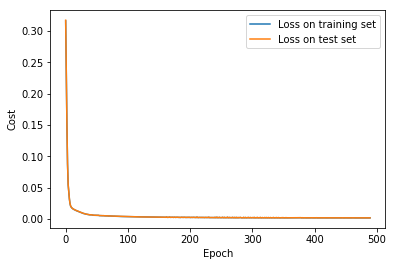

In [21]:
#Plot the loss
def plot_loss_list(loss_list = rnn.loss_list, loss_validation = rnn.loss_validation):
    plt.plot(rnn.loss_list, label='Loss on training set')
    plt.plot(rnn.loss_validation,  label='Loss on test set')
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.show()

plot_loss_list(rnn.loss_list)

In [22]:
folder = get_rnn_folder(ncells = ncells, cell_type = cell_type, activation = activation)
#rnn, data = full_load(folder)
#minibatches, test_input, test_target = data

In [23]:
test_input.shape

(4690, 7, 3)

In [24]:
def rnn_test(rnn, test_input= test_input, test_target= test_target, scalor= rnn.scalor):
    
    #Here I predict based on my test set
    test_pred = rnn.predict(test_input)
    
    #Here i subtract a prediction (random particle) from the target to get an idea of the predictions
    #scaler_inv(test_input, scalerfunc = func)[0,:,:]
    diff = scaler_inv(test_pred, scalerfunc = func, scalor= scalor)-scaler_inv(test_target, scalerfunc = func, scalor= scalor)
    print(diff[random.randint(0,test_pred.shape[0]),:,:])
    
    #Here I evaluate my model on the test set based on mean_squared_error
    loss = rnn.sess.run(rnn.cost, feed_dict={rnn.X:test_input, rnn.Y:test_target})
    print("Loss on test set:", loss)
    
    return test_pred, loss

In [25]:
test_pred, test_loss = rnn_test(rnn=rnn)

[[ 0.22876946 -1.05757492  0.05743555]
 [ 0.4227805  -1.49878024 -0.45964226]
 [ 1.57940168 -0.0964699  -0.29063407]
 [ 8.23204061 -7.21131909  0.2346999 ]
 [ 0.63359657 -1.23937142  0.23865187]
 [ 3.5459507  -2.39105333  0.56137755]
 [ 0.0832766  -0.32882895  0.49288811]
 [ 0.          0.          0.        ]]
Loss on test set: 0.0018604315
